In [1]:
"""
# Define pitch
F = [0,1,0] ; E_sharp = [0,1,0]
C = [1,0,1] ; B_sharp = [1,0,1] 
G = [0,-1,2]
D = [-1,0,3]
A = [0,1,4]
E = [1,0,5]  ; F_flat = [1,0,5]
B = [0,-1,6]  ; C_flat = [0,-1,6]
F_sharp = [-1,0,7] ; G_flat = [-1,0,7]
C_sharp = [0,1,8] ; D_flat = [0,1,8]
G_sharp = [1,0,9] ; A_flat = [1,0,9]
D_sharp = [0,-1,10] ; E_flat = [0,-1,10]
A_sharp = [-1,0,11] ; B_flat = [-1,0,11]
"""
print()

In [1]:
import librosa
import os, sys
import numpy as np
from pydub import AudioSegment
from pydub.utils import make_chunks
import warnings
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools
from librosa import display
warnings.filterwarnings('ignore')
import mido
from mido import Message, MidiFile, MidiTrack

/home/hsuan/env1/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [42]:
pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
pitch_ary = np.array(pitch_ary)

def get_pitch(num):
    pitch_list = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    return pitch_list[num%12] 

def get_midi(filename, track=0):    
   ## read midi file
    mid = MidiFile(filename)
    ## get midi information
    temp=[]
    for msg in mid.tracks[track]:
        temp.append(msg)
    ## only extract note_on and note_off
    midi_list = []
    for i in range(len(temp)):
        if ('note_on' in str(temp[i]) or 'note_off' in str(temp[i])) and 'velocity=0' not in str(temp[i]):
#         if ('note_on' in str(temp[i]) or 'note_off' in str(temp[i])):
            midi_list.append(temp[i])   
    return midi_list

## get all clip 
def get_dirs(path):
    dirs = os.listdir(path)
    return dirs  # file list


## transform pitch to array in space
def pitch_to_ary(notes):
    pitch_ary = [[1,0,1], [0,1,8], [-1,0,3], [0,-1,10], [1,0,5], [0,1,0], [-1,0,7],\
                 [0,-1,2], [1,0,9], [0,1,4], [-1,0,11], [0,-1,6]]
    pitch_ary = np.array(pitch_ary)
    return pitch_ary[notes]


## count CE
def count_CE(notes_seq):
    c = Counter(notes_seq)
    Dab = 0
    sum_dp = 0
    for i in range(len(notes_seq)):
        pij = (pitch_to_ary(notes_seq[i]))
        dij = 1
        Dab = sum(c.values())
        sum_dp += (dij * pij)  
        CE = sum_dp/Dab   
    return CE

def get_key(CE, pitch_ary):
    key = []
    for i in range(len(pitch_ary)):
        key.append(abs(pitch_ary[i][0]-int(CE[0])) + abs(pitch_ary[i][1]-int(CE[1])) + \
                  abs(pitch_ary[i][2]-int(CE[2])))
    predict_key = pitch_trans(key.index(min(key)))
    return predict_key

In [51]:
sleeping_music = sorted(get_dirs('MidiSample/midi'))

In [52]:
note_list = []; temp=[]
for i in range(len(sleeping_midi)):
    midi_list = get_midi('MidiSample/midi/'+sleeping_music[i])
    for i in range(len(midi_list)):
        temp.append(get_pitch(midi_list[i].note))
    note_list.append(temp)

In [53]:
pitch_list = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']


result=[];key_=[]
for i in range(len(note_list)):
    for j in range(1,int(len(note_list[i])/4)):
        temp=[]
        temp.append(pitch_list.index(note_list[i][j]))
        temp.append(pitch_list.index(note_list[i][j+1]))
        temp.append(pitch_list.index(note_list[i][j+2]))
        temp.append(pitch_list.index(note_list[i][j+3]))
        j=j+4
        CE = count_CE(temp)
        key_.append(get_key(CE, pitch_ary))
    result.append(key_)

In [54]:
len(result)

31

### Get Chord (4 beats)

In [55]:
## Analysis chord and pitch

"""
Analyze how chord changing
key_list: sleeping_key (len = 75)
n_gram: how many chord you want to see (1 gram = 1 chord = 4 sec)

"""


def n_gram(key_list, ngram):
    ngram_key = []
    flattened = [val for sublist in key_list for val in sublist]
    for i in range(int(len(flattened)-ngram)):
        ngram_key.append(flattened[i : ngram +i])
    count_ngram = dict([])
    for i in ngram_key:
        i=str(i)
        i = i.replace("[", "")
        i = i.replace("]", "")
        if i in count_ngram:
            count_ngram[i] += 1
        else:
            count_ngram[i] = 1
    return count_ngram 

def n_gram2(key_list, ngram):
    ngram_key = []
#     flattened = [val for sublist in key_list for val in sublist]
    for i in range(int(len(key_list)-3)):
        ngram_key.append(key_list[i : ngram+i])
    count_ngram = dict([])
    for i in ngram_key:
        i=str(i)
        i = i.replace("[", "")
        i = i.replace("]", "")
        if i in count_ngram:
            count_ngram[i] += 1
        else:
            count_ngram[i] = 1
    return count_ngram 

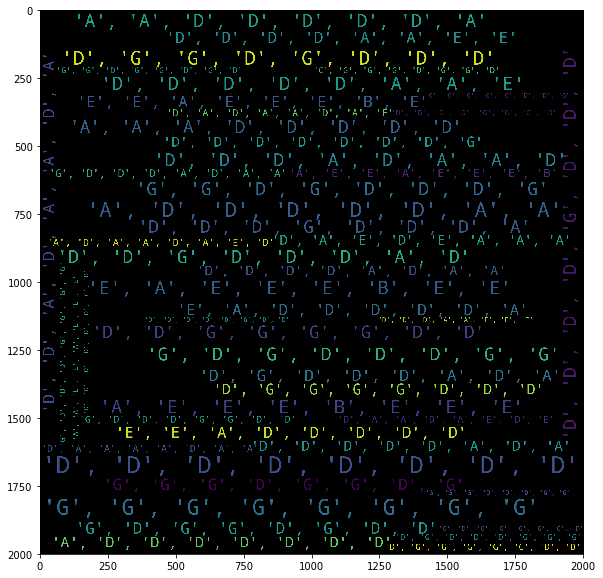

In [56]:
from wordcloud import WordCloud
def plot_wordcloud(data, max_word):
    wordcloud = WordCloud(max_words=max_word, max_font_size=1500,background_color='black',width=2000, height=2000,margin=2).\
    generate_from_frequencies(data)
    plt.figure(figsize=(10,10))
    plt.tight_layout()
    plt.imshow(wordcloud)
    
a = n_gram(result,8)
plot_wordcloud(a,50)

In [57]:
## pitch matching

perfect_five = [['C','G'],['G','D'],['D','A'],['A','E'],['E','B'],['B','F#'],['F#','C#'],['C#','G#'],
                ['G#','D#(E-)'],['D#(E-)','A#(B-)'],['A#(B-)','F'],['F','C']]

same_pitch2 = [['C','C','C'],['D','D','D'],['A','A','A'],['E','E','E'],['B','B','B'],['F#','F#','F#'],
              ['C#','C#','C#'],['G#','G#','G#'], ['D#(E-)','D#(E-)','D#(E-)'],
              ['A#(B-)','A#(B-)','A#(B-)'],['F','F','F'],['G','G','G']]

same_pitch = [['C','C'],['D','D'],['A','A'],['E','E'],['B','B'],['F#','F#'],['C#','C#'],
              ['G#','G#'], ['D#(E-)','D#(E-)'],['A#(B-)','A#(B-)'],['F','F'],['G','G']]

big_three = [['C','E'],['D','F#'],['E','G#'],['F','A'],['G','B'],['A','C#'],['B','D#'],
             ['C#','F'],['D#(E-)','G'],['F#','A#(B-)'],['G#','C'],['A#','D']]

small_three = [['C','D#'],['D','F'],['E','G'],['F','G#'],['G','A#'],['A','C'],['B','D'],
             ['C#','E'],['D#(E-)','F#'],['F#','A'],['G#','B'],['A#','C#']]

four_pitch = [['C','F'],['D','G'],['E','A'],['F','A#(B-)'],['G','C'],['A','D'],['B','E'],
             ['C#','F#'],['D#(E-)','G#'],['F#','B'],['G#','C#'],['A#','D#(E-)']]

whole_tone = [['C','D'],['D','E'],['E','F#'],['F','G'],['G','A'],['A','B'],['B','C#'],
             ['C#','D#(E-)'],['D#(E-)','F'],['F#','G#'],['G#','A#'],['A#','C'],
             ['D','C'],['E','D'],['F#','E'],['G','F'],['A','G'],['B','A'],['C#','B'],
             ['D#(E-)','C#'],['F','D#(E-)'],['G#','F#'],['A#','G#'],['C','A#']]

In [58]:
## Chord progression
for idx in range(len(result)):
    perfect = 0; same = 0; non = 0; big3 = 0; small3 = 0
    perfect_ = 0; same_ = 0; non_ = 0; big3_ = 0; small3_ = 0
    for i in range(len(result[idx])):
        if result[idx][i:i+2] in perfect_five:
            perfect = perfect+1
        elif result[idx][i:i+2] in big_three:
            big3 = big3+1
        elif result[idx][i:i+2] in small_three:
            small3 = small3+1
        else:
            non = non+1
    for i in range(len(result[idx])):
        if result[idx][i:i+3] in same_pitch:
            same = same+1
    try:
        perfect_ = round(perfect/len(result[idx]) *100,2)
        same_ = round(same/len(result[idx]) *100,2)
        non_ = round(non/len(result[idx]) *100,2)
        big3_ = round(big3/len(result[idx]) *100,2)
        small3_ = round(small3/len(result[idx]) *100,2)
    except:
        pass
    print(idx,sleeping_music[idx])
    print("Perfect 5:", perfect_, '%')
    print("Big three:",big3_, '%')
    print("Small",small3_, '%')
    print("Stable:",same_, '%')
    print("Other",non_, '%')
    print()

0 10.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

1 11.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

2 12.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

3 13.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

4 14.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

5 15.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

6 16.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

7 17.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

8 18.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

9 19.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

10 1小時心靈音樂學習輕音樂.mid
Perfect 5: 23.41 %
Big three: 0.0 %
Small 0.64 %
Stable: 0.0 %
Other 75.95 %

11 2.mid
Perfect 5: 23.41 %
Big 

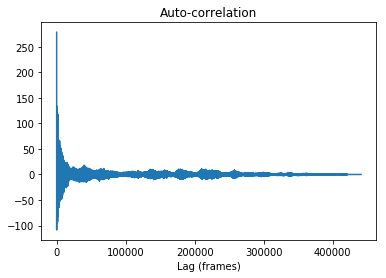

In [327]:
y1, sr = librosa.load('./music/classic/'+ sleeping_music[3],duration = 20, res_type = "kaiser_fast")
    
# Compute autocorrelation of input segment.
r = librosa.autocorrelate(y1)

plt.plot(r)
plt.title('Auto-correlation')
plt.xlabel('Lag (frames)')

# Define lower and upper limits for the autocorrelation argmax.
i_min = sr/2000
i_max = sr/50
r[:int(i_min)] = 0
r[int(i_max):] = 0

# Find the location of the maximum autocorrelation.
i = r.argmax()
f0 = float(sr)/i

In [322]:
len(r)

441000

In [336]:
temp3=[];temp=[]
y1, sr = librosa.load('./music/classic/'+ sleeping_music[3],duration = 20, res_type = "kaiser_fast")
## onset detection
o_env = librosa.onset.onset_strength(y1, sr=sr, hop_length=128)
onset_frames = librosa.onset.onset_detect(y=y1, onset_envelope=o_env, sr=sr, hop_length=128)

## pitch detection
b = librosa.feature.chroma_stft(y=y1, sr=sr, n_fft=1024, hop_length=128)

temp =[]
for i in range(len(onset_frames)): 
    temp.append(np.argsort(b[:,onset_frames[i]])[-1])  
for i in range(len(temp)):
    temp3.append(pitch_trans(temp[i]))    

## count CE
CE = (count_CE(temp))
temp2.append(get_key(CE, pitch_ary))

In [239]:
## Chord progression

for idx in range(len(sleeping_music)):
    same = 0; same_ = 0
    for i in range(len(pitch[idx])):
        if pitch[idx][i:i+3] in same_pitch:
            same = same+1
    
    
    print(idx,sleeping_music[idx])
    print("Stable:",same/len(pitch[idx])*100)
    print()

0 Beethoven Fur Elise 貝多芬 獻給愛麗絲.wav
Stable: 10.56701030927835

1 Canon 卡農 (Johann Pachelbel ) 鋼琴 Jason Piano.wav
Stable: 11.354309165526676

2 Mozart Sonata No.16 K.545 Mov.1  莫札特 奏鳴曲 16號 第一樂章.wav
Stable: 28.419328419328423

3 classic1.wav
Stable: 20.679886685552407

4 classic11.wav
Stable: 6.821480406386067

5 classic2.wav


ZeroDivisionError: division by zero

In [224]:
len(sleeping_key)

19

## Analysis

In [116]:
## Chord progression
for idx in range(len(sleeping_music)):
    perfect = 0; same = 0; non = 0; big3 = 0; small3 = 0
    perfect_ = 0; same_ = 0; non_ = 0; big3_ = 0; small3_ = 0
    for i in range(len(sleeping_key[idx])):
        if sleeping_key[idx][i:i+2] in perfect_five:
            perfect = perfect+1
        elif sleeping_key[idx][i:i+2] in big_three:
            big3 = big3+1
        elif sleeping_key[idx][i:i+2] in small_three:
            small3 = small3+1
        else:
            non = non+1
    for i in range(len(sleeping_key[idx])):
        if sleeping_key[idx][i:i+3] in same_pitch:
            same = same+1
    try:
        perfect_ = round(perfect/len(sleeping_key[idx]) *100,2)
        same_ = round(same/len(sleeping_key[idx]) *100,2)
        non_ = round(non/len(sleeping_key[idx]) *100,2)
        big3_ = round(big3/len(sleeping_key[idx]) *100,2)
        small3_ = round(small3/len(sleeping_key[idx]) *100,2)
    except:
        pass
    print(idx,sleeping_music[idx])
    print("Perfect 5:", perfect_, '%')
    print("Big three:",big3_, '%')
    print("Small",small3_, '%')
    print("Stable:",same_, '%')
    print("Other",non_, '%')
    print()

0 Beethoven Fur Elise 貝多芬 獻給愛麗絲.wav
Perfect 5: 11.11 %
Big three: 2.22 %
Small 2.22 %
Stable: 6.67 %
Other 84.44 %

1 Canon 卡農 (Johann Pachelbel ) 鋼琴 Jason Piano.wav
Perfect 5: 16.67 %
Big three: 1.67 %
Small 6.67 %
Stable: 0.0 %
Other 75.0 %

2 Mozart Sonata No.16 K.545 Mov.1  莫札特 奏鳴曲 16號 第一樂章.wav
Perfect 5: 20.34 %
Big three: 0.0 %
Small 0.0 %
Stable: 6.78 %
Other 79.66 %

3 classic1.wav
Perfect 5: 13.33 %
Big three: 1.67 %
Small 0.0 %
Stable: 6.67 %
Other 85.0 %

4 classic10.wav
Perfect 5: 15.79 %
Big three: 0.0 %
Small 0.0 %
Stable: 42.11 %
Other 84.21 %

5 classic11.wav
Perfect 5: 15.0 %
Big three: 1.67 %
Small 1.67 %
Stable: 1.67 %
Other 81.67 %

6 classic2.wav
Perfect 5: 30.0 %
Big three: 0.0 %
Small 0.0 %
Stable: 13.33 %
Other 70.0 %

7 classic3.wav
Perfect 5: 16.67 %
Big three: 0.0 %
Small 1.67 %
Stable: 0.0 %
Other 81.67 %

8 classic4.wav
Perfect 5: 10.0 %
Big three: 3.33 %
Small 10.0 %
Stable: 3.33 %
Other 76.67 %

9 classic5.wav
Perfect 5: 16.67 %
Big three: 0.0 %
Small 0.0

In [17]:
## Check if it has a dominant key
for idx in range(len(sleeping_music)):
    print(idx, n_gram(pitch[idx], 1))
    print()

0 [[['E'], 170], [['A'], 151], [['C'], 110], [['B'], 86], [['G#'], 56], [['D#(E-)'], 55], [['D'], 53], [['G'], 41], [['F'], 30], [['A#(B-)'], 20], [['C#'], 3], [['F#'], 1]]

1 [[['C#'], 236], [['F'], 129], [['G#'], 105], [['A#(B-)'], 71], [['D#(E-)'], 65], [['C'], 50], [['F#'], 38], [['G'], 5], [['B'], 3], [['D'], 2], [['E'], 1], [['A'], 1]]

2 [[['A#(B-)'], 28], [['G#'], 25], [['F'], 18], [['D#(E-)'], 16], [['G'], 15], [['C'], 12], [['F#'], 11], [['C#'], 4], [['E'], 3], [['D'], 2]]

3 [[['G'], 284], [['D'], 243], [['C'], 216], [['A'], 202], [['B'], 189], [['E'], 189], [['F'], 128], [['F#'], 45], [['A#(B-)'], 40], [['C#'], 33], [['G#'], 20], [['D#(E-)'], 6]]

4 [[['D#(E-)'], 120], [['F'], 105], [['G'], 89], [['C'], 65], [['D'], 64], [['A#(B-)'], 50], [['B'], 34], [['G#'], 31], [['A'], 24], [['C#'], 23], [['F#'], 6], [['E'], 3]]

5 [[['C#'], 164], [['G#'], 153], [['F#'], 143], [['E'], 93], [['D#(E-)'], 75], [['B'], 70], [['C'], 61], [['A'], 50], [['G'], 41], [['A#(B-)'], 24], [['D'], 23

In [ ]:
# o_env = librosa.onset.onset_strength(y1, sr=sr)
# times = librosa.frames_to_time(np.arange(len(o_env)), sr=sr)
# onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

# import matplotlib.pyplot as plt
# D = np.abs(librosa.stft(y1))
# plt.figure()
# ax1 = plt.subplot(2, 1, 1)
# librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
#                           x_axis='time', y_axis='log')
# plt.title('Power spectrogram')
# plt.subplot(2, 1, 2, sharex=ax1)
# plt.plot(times, o_env, label='Onset strength')
# plt.vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
#             linestyle='--', label='Onsets')
# plt.axis('tight')
# plt.legend(frameon=True, fram1ealpha=0.75)

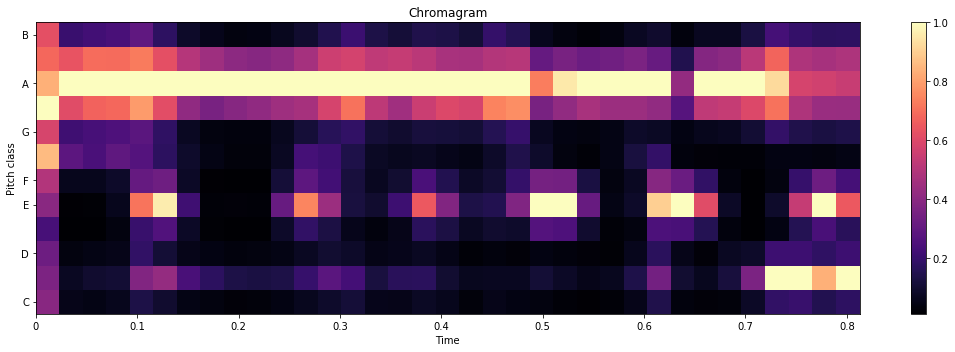

In [37]:
# for i in range(2):
# y,sr = librosa.load('./test/soda/'+ clip_list2[i])    
b = librosa.feature.chroma_stft(y=y1, sr=sr,  n_fft=1024, hop_length=512)
plt.figure(figsize=(15, 5))
librosa.display.specshow(b, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

In [ ]:
# ## split audio
# def chunk_wav(file, chunk_ms,folder, title):
#     chunks = make_chunks(file, chunk_ms)
#     # Export all of the individual chunks as wav files
#     for i, chunk in enumerate(chunks):
#         chunk_name = os.path.join("./test", folder,"{0}_chunk{1}.wav".format(title, i))
#         librosa.output.write_wav(chunk_name, chunk, sr)


In [24]:
y,sr = librosa.load('./music/sleeping/m2.wav', duration = 1800)   

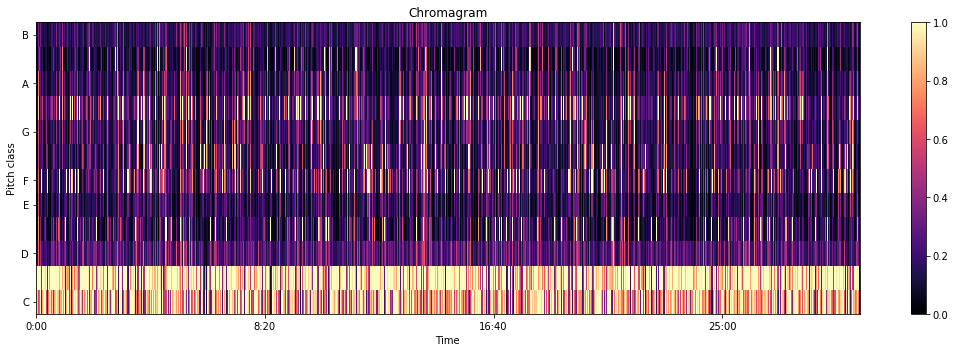

In [25]:
b = librosa.feature.chroma_stft(y=y, sr=sr,  n_fft=1024, hop_length=512)
plt.figure(figsize=(15, 5))
librosa.display.specshow(b, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()